# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

D:\Data\Python\3.10.2\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Data\Python\3.10.2\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\Data\Python\3.10.2\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.arange(0, 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

display(ALPHAS)

array([0.    , 0.0125, 0.025 , 0.0375, 0.05  , 0.0625, 0.075 , 0.0875,
       0.1   , 0.1125, 0.125 , 0.1375, 0.15  , 0.1625, 0.175 , 0.1875,
       0.2   , 0.2125, 0.225 , 0.2375, 0.25  , 0.2625, 0.275 , 0.2875,
       0.3   , 0.3125, 0.325 , 0.3375, 0.35  , 0.3625, 0.375 , 0.3875,
       0.4   , 0.4125, 0.425 , 0.4375, 0.45  , 0.4625, 0.475 , 0.4875,
       0.5   ])

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)


def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y


X, y = generate_samples()

### Plot samples

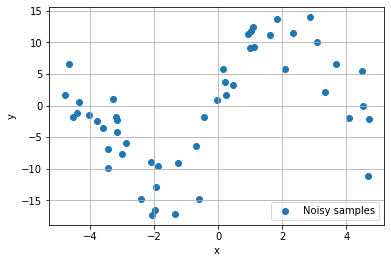

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')


plot_scatter(X, y)

### Split

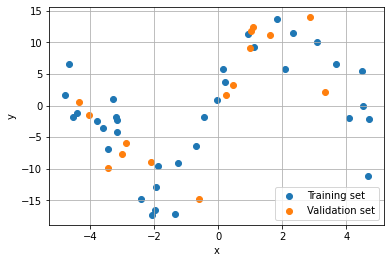

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000)

    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])


display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

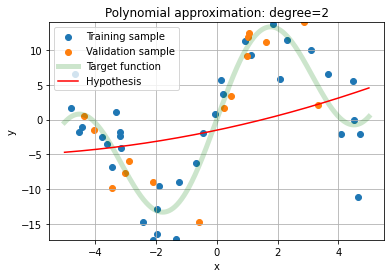

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y), max(y)))
    plt.legend(loc='best')
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()


plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

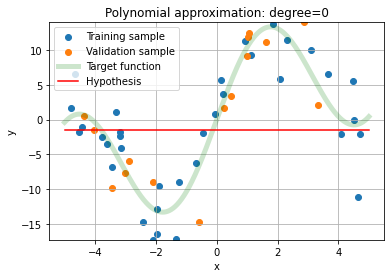

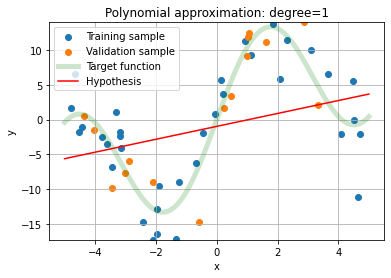

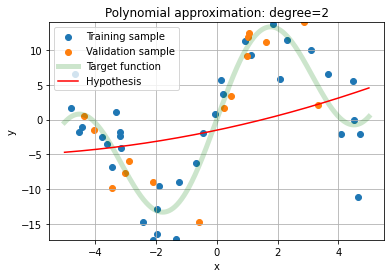

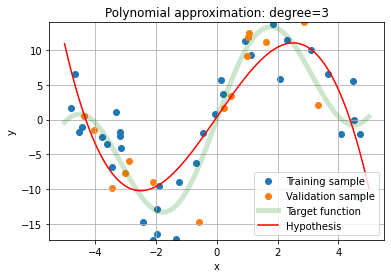

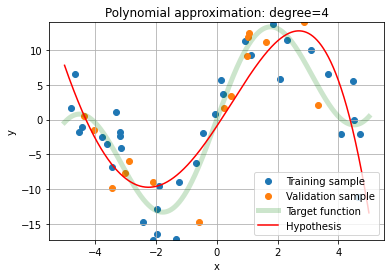

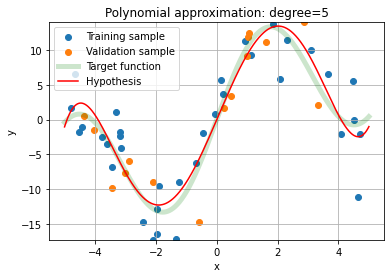

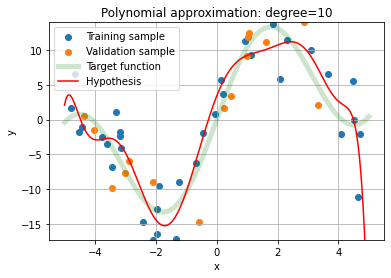

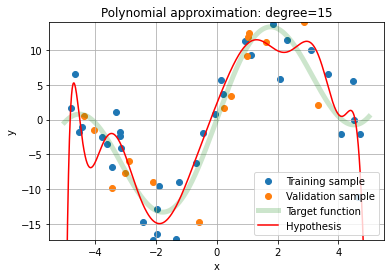

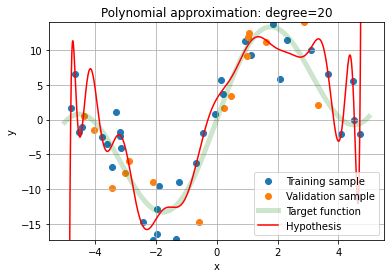

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

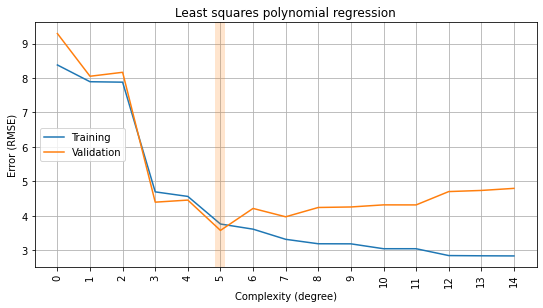

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel,
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label)
        plt.legend(loc='center right')
    plt.show()


rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))

plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

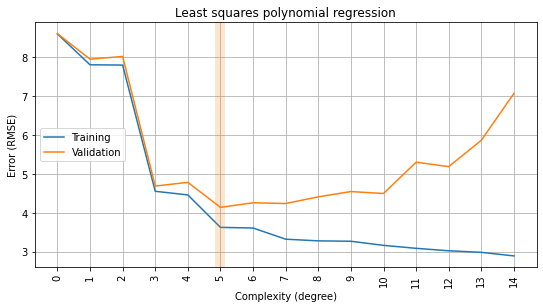

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))

plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

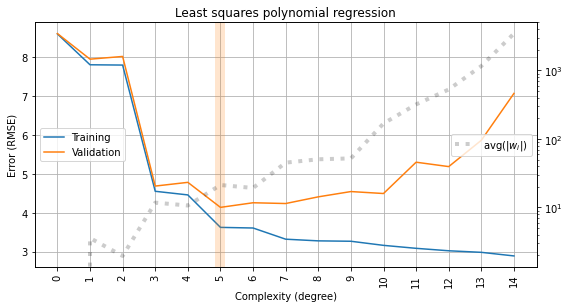

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(
        # average over CV folds
        np.mean([
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))

plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

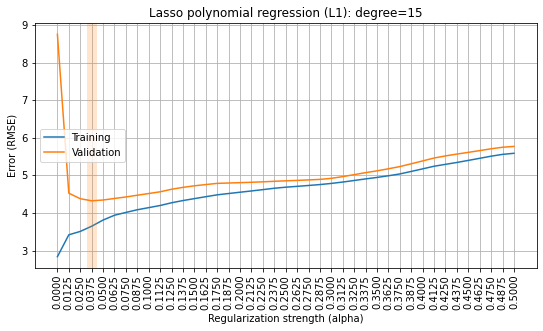

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha),
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))

plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

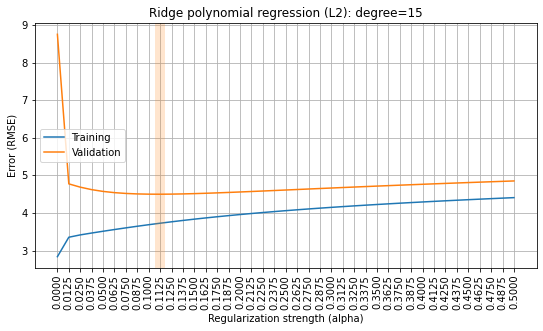

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha),
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))

plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes

data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

## Solution

In [21]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Let's look at our data

In [22]:
display(X_diabetes.join(y_diabetes))
display(X_diabetes.shape)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038,0.051,0.062,0.022,-0.044,-0.035,-0.043,-0.003,0.020,-0.018,151.000
1,-0.002,-0.045,-0.051,-0.026,-0.008,-0.019,0.074,-0.039,-0.068,-0.092,75.000
2,0.085,0.051,0.044,-0.006,-0.046,-0.034,-0.032,-0.003,0.003,-0.026,141.000
3,-0.089,-0.045,-0.012,-0.037,0.012,0.025,-0.036,0.034,0.023,-0.009,206.000
4,0.005,-0.045,-0.036,0.022,0.004,0.016,0.008,-0.003,-0.032,-0.047,135.000
...,...,...,...,...,...,...,...,...,...,...,...
437,0.042,0.051,0.020,0.060,-0.006,-0.003,-0.029,-0.003,0.031,0.007,178.000
438,-0.006,0.051,-0.016,-0.068,0.049,0.079,-0.029,0.034,-0.018,0.044,104.000
439,0.042,0.051,-0.016,0.017,-0.037,-0.014,-0.025,-0.011,-0.047,0.015,132.000
440,-0.045,-0.045,0.039,0.001,0.016,0.015,-0.029,0.027,0.045,-0.026,220.000


(442, 10)

In [23]:
X_diabetes.join(y_diabetes).describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000
mean,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,152.133
std,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,77.093
min,-0.107,-0.045,-0.090,-0.112,-0.127,-0.116,-0.102,-0.076,-0.126,-0.138,25.000
25%,-0.037,-0.045,-0.034,-0.037,-0.034,-0.030,-0.035,-0.039,-0.033,-0.033,87.000
50%,0.005,-0.045,-0.007,-0.006,-0.004,-0.004,-0.007,-0.003,-0.002,-0.001,140.500
75%,0.038,0.051,0.031,0.036,0.028,0.030,0.029,0.034,0.032,0.028,211.500
max,0.111,0.051,0.171,0.132,0.154,0.199,0.181,0.185,0.134,0.136,346.000


Let split our data to train/test

In [24]:
train_size = 0.7

X_train, X_test, Y_train, Y_test = train_test_split(X_diabetes, y_diabetes, train_size=train_size)
display(X_train.shape)
display(X_test.shape)
display(Y_train.shape)
display(Y_test.shape)

(309, 10)

(133, 10)

(309, 1)

(133, 1)

Let define metrics function to have fast and clear access for necessary metrics 

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score


def metrics(y_true, y_pred):
    return pd.Series({
        'mse': mean_squared_error(y_true, y_pred),
        'mae': mean_absolute_error(y_true, y_pred),
        'mape': mean_absolute_percentage_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
    })

Let's try to define under- and overfitting from 1st to 10th degree using just simple Linear Regression with all polynomial features

In [26]:
def execute_model(models, x_train, x_test, y_train, y_test, cv):
    result_df = models['model'].apply(lambda model: metrics(y_train, model.predict(x_train))).add_suffix('_train')
    result_df = result_df.join(
        models['model'].apply(lambda model: metrics(y_test, model.predict(x_test))).add_suffix('_test'))

    result_cv = models.apply(lambda model: cross_validate(
        model['model'],
        pd.concat([x_train, x_test]),
        pd.concat([y_train, y_test]),
        cv=cv,
        scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'),
        return_train_score=True), axis=1, result_type='expand')

    result_cv = result_cv.apply(lambda r: r.apply(lambda c: np.mean(c)))
    result_df['mse_cv_train'] = abs(result_cv['train_neg_mean_squared_error'])
    result_df['mae_cv_train'] = abs(result_cv['train_neg_mean_absolute_error'])
    result_df['mape_cv_train'] = abs(result_cv['train_neg_mean_absolute_percentage_error'])
    result_df['r2_cv_train'] = result_cv['train_r2']
    result_df['mse_cv_test'] = abs(result_cv['test_neg_mean_squared_error'])
    result_df['mae_cv_test'] = abs(result_cv['test_neg_mean_absolute_error'])
    result_df['mape_cv_test'] = abs(result_cv['test_neg_mean_absolute_percentage_error'])
    result_df['r2_cv_test'] = result_cv['test_r2']

    return result_df

In [27]:
from sklearn.preprocessing import FunctionTransformer


def poly_model(model, degree, features):
    return Pipeline([
        ('ft', FunctionTransformer(lambda x: x[features])),
        ('pol', PolynomialFeatures(degree)),
        ('sca', StandardScaler()),
        ('model', model)
    ])

#### Linear Model

In [28]:
max_degree = 15
cv = 5
features = ['s1', 's2', 's3', 's4']
linear_models = pd.DataFrame({'degree': np.arange(1, max_degree + 1)})
linear_models['model'] = linear_models['degree'].apply(
    lambda x: poly_model(LinearRegression(), x, features).fit(X_train, Y_train))

In [29]:
linear_model_results = execute_model(linear_models, X_train, X_test, Y_train, Y_test, cv)
linear_model_results.insert(0, 'degree', linear_models['degree'])
linear_model_results

,degree,mse_train,mae_train,mape_train,r2_train,mse_test,mae_test,mape_test,r2_test,mse_cv_train,mae_cv_train,mape_cv_train,r2_cv_train,mse_cv_test,mae_cv_test,mape_cv_test,r2_cv_test
0,1,4104.951,51.386,0.451,0.319,4152.459,53.098,0.478,0.271,4098.842,51.829,0.461,0.308,4226.405,52.543,0.468,0.277
1,2,3624.690,48.586,0.425,0.398,3900.926,51.152,0.467,0.315,3624.428,48.451,0.429,0.388,3947.930,50.963,0.449,0.324
2,3,3440.719,46.704,0.404,0.429,4751.550,54.281,0.487,0.166,3462.358,47.009,0.417,0.415,4376.303,53.117,0.468,0.249
3,4,3003.774,42.314,0.371,0.501,135439.287,89.551,0.635,-22.786,3059.898,42.999,0.387,0.483,26570.985,66.846,0.565,-3.547
4,5,2298.664,35.332,0.312,0.619,1583706.171,227.491,1.488,-277.127,2495.439,37.499,0.341,0.578,269144.840,121.534,1.096,-43.702
5,6,6865.917,62.218,0.538,-0.139,1495404518.101,5399.095,29.681,-262618.271,20965.318,92.726,0.812,-2.518,109347602.776,1879.206,12.835,-18214.280
6,7,0.000,0.000,0.000,1.000,109033711365918.391,1753983.423,12080.324,-19148232767.172,314.257,8.188,0.083,0.947,13660639737575.854,312033.670,2010.775,-2318044591.712
7,8,0.000,0.000,0.000,1.000,624668019740795.500,3569361.287,24836.812,-109702664385.868,0.000,0.000,0.000,1.000,5062642092753594.000,6200490.770,49950.458,-847196698951.458
8,9,0.000,0.000,0.000,1.000,1762695702354705.000,5657245.891,39836.731,-309560292731.501,0.000,0.000,0.000,1.000,146110470047487840.000,20304458.590,232309.325,-24095696952557.535
9,10,0.000,0.000,0.000,1.000,4327269783345656.500,7988899.867,54692.423,-759944498119.432,0.000,0.000,0.000,1.000,48123398827263976.000,13474883.189,150150.916,-7946718354119.611


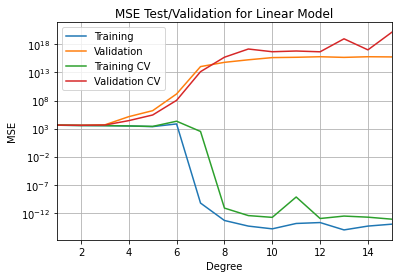

In [30]:
plt.plot(linear_model_results['degree'], linear_model_results['mse_train'], label='Training')
plt.plot(linear_model_results['degree'], linear_model_results['mse_test'], label='Validation')
plt.plot(linear_model_results['degree'], linear_model_results['mse_cv_train'], label='Training CV')
plt.plot(linear_model_results['degree'], linear_model_results['mse_cv_test'], label='Validation CV')
plt.title('MSE Test/Validation for Linear Model')
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.gca().set_xlim([min(linear_model_results['degree']), max(linear_model_results['degree'])])
plt.yscale('log')
plt.show()

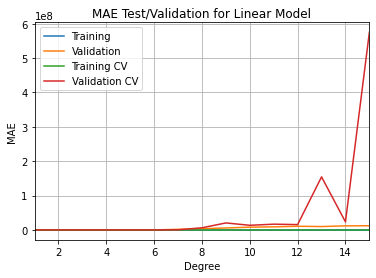

In [31]:
plt.plot(linear_model_results['degree'], linear_model_results['mae_train'], label='Training')
plt.plot(linear_model_results['degree'], linear_model_results['mae_test'], label='Validation')
plt.plot(linear_model_results['degree'], linear_model_results['mae_cv_train'], label='Training CV')
plt.plot(linear_model_results['degree'], linear_model_results['mae_cv_test'], label='Validation CV')
plt.title('MAE Test/Validation for Linear Model')
plt.xlabel('Degree')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()
plt.gca().set_xlim([min(linear_model_results['degree']), max(linear_model_results['degree'])])
plt.show()

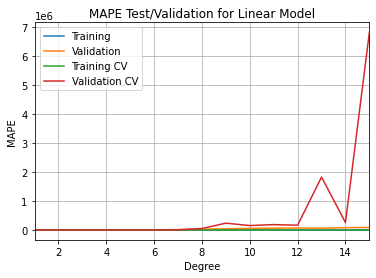

In [32]:
plt.plot(linear_model_results['degree'], linear_model_results['mape_train'], label='Training')
plt.plot(linear_model_results['degree'], linear_model_results['mape_test'], label='Validation')
plt.plot(linear_model_results['degree'], linear_model_results['mape_cv_train'], label='Training CV')
plt.plot(linear_model_results['degree'], linear_model_results['mape_cv_test'], label='Validation CV')
plt.title('MAPE Test/Validation for Linear Model')
plt.xlabel('Degree')
plt.ylabel('MAPE')
plt.grid(True)
plt.legend()
plt.gca().set_xlim([min(linear_model_results['degree']), max(linear_model_results['degree'])])
plt.show()

So, we see, that 
* At high degree ($\ge4$) MAE (Mean Absolute Error) and MAPE (Mean Absolute Percentage Error) are very close for cross-validation and no cross-validation value
* The best result for validation sets are at degree `0`
* No underfitting found
* Overfitting started at value `3`

#### L1

In [33]:
max_degree = 15
iter_count = 10000

lasso_models = pd.DataFrame({'alpha': ALPHAS[1:]})
lasso_models['model'] = lasso_models['alpha'].apply(
    lambda alpha: poly_model(Lasso(alpha=alpha, random_state=SEED, max_iter=iter_count),
                             max_degree, features).fit(X_train, Y_train))

D:\Data\Python\3.10.2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.721e+05, tolerance: 1.862e+02
  model = cd_fast.enet_coordinate_descent(
D:\Data\Python\3.10.2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.209e+04, tolerance: 1.862e+02
  model = cd_fast.enet_coordinate_descent(
D:\Data\Python\3.10.2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.591e+04, tolerance: 1.862e

In [ ]:
lasso_model_results = execute_model(lasso_models, X_train, X_test, Y_train, Y_test, cv)
lasso_model_results.insert(0, 'alpha', lasso_models['alpha'])
lasso_model_results

D:\Data\Python\3.10.2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.711e+05, tolerance: 2.038e+02
  model = cd_fast.enet_coordinate_descent(
D:\Data\Python\3.10.2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.088e+05, tolerance: 2.084e+02
  model = cd_fast.enet_coordinate_descent(
D:\Data\Python\3.10.2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.462e+05, tolerance: 2.058e

D:\Data\Python\3.10.2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.047e+03, tolerance: 2.104e+02
  model = cd_fast.enet_coordinate_descent(
D:\Data\Python\3.10.2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.610e+03, tolerance: 2.038e+02
  model = cd_fast.enet_coordinate_descent(
D:\Data\Python\3.10.2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.134e+03, tolerance: 2.084e

In [ ]:
plt.plot(lasso_model_results['alpha'], lasso_model_results['mse_train'], label='Training')
plt.plot(lasso_model_results['alpha'], lasso_model_results['mse_test'], label='Validation')
plt.plot(lasso_model_results['alpha'], lasso_model_results['mse_cv_train'], label='Training CV')
plt.plot(lasso_model_results['alpha'], lasso_model_results['mse_cv_test'], label='Validation CV')
plt.title('MSE Test/Validation for Lasso Model')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.gca().set_xlim([min(lasso_model_results['alpha']), max(lasso_model_results['alpha'])])
plt.yscale('log')
plt.show()

In [ ]:
plt.plot(lasso_model_results['alpha'], lasso_model_results['mae_train'], label='Training')
plt.plot(lasso_model_results['alpha'], lasso_model_results['mae_test'], label='Validation')
plt.plot(lasso_model_results['alpha'], lasso_model_results['mae_cv_train'], label='Training CV')
plt.plot(lasso_model_results['alpha'], lasso_model_results['mae_cv_test'], label='Validation CV')
plt.title('MAE Test/Validation for Lasso Model')
plt.xlabel('Alpha')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()
plt.gca().set_xlim([min(lasso_model_results['alpha']), max(lasso_model_results['alpha'])])
plt.show()

In [ ]:
plt.plot(lasso_model_results['alpha'], lasso_model_results['mape_train'], label='Training')
plt.plot(lasso_model_results['alpha'], lasso_model_results['mape_test'], label='Validation')
plt.plot(lasso_model_results['alpha'], lasso_model_results['mape_cv_train'], label='Training CV')
plt.plot(lasso_model_results['alpha'], lasso_model_results['mape_cv_test'], label='Validation CV')
plt.title('MAPE Test/Validation for Lasso Model')
plt.xlabel('Alpha')
plt.ylabel('MAPE')
plt.grid(True)
plt.legend()
plt.gca().set_xlim([min(lasso_model_results['alpha']), max(lasso_model_results['alpha'])])
plt.show()

#### L2

In [ ]:
max_degree = 15
iter_count = 1000

ridge_models = pd.DataFrame({'alpha': ALPHAS[1:]})
ridge_models['model'] = ridge_models['alpha'].apply(
    lambda alpha: poly_model(Ridge(alpha=alpha, random_state=SEED, max_iter=iter_count),
                             max_degree, features).fit(X_train, Y_train))

In [ ]:
ridge_model_results = execute_model(ridge_models, X_train, X_test, Y_train, Y_test, cv)
ridge_model_results.insert(0, 'alpha', lasso_models['alpha'])
ridge_model_results

In [ ]:
plt.plot(ridge_model_results['alpha'], ridge_model_results['mse_train'], label='Training')
plt.plot(ridge_model_results['alpha'], ridge_model_results['mse_test'], label='Validation')
plt.plot(ridge_model_results['alpha'], ridge_model_results['mse_cv_train'], label='Training CV')
plt.plot(ridge_model_results['alpha'], ridge_model_results['mse_cv_test'], label='Validation CV')
plt.title('MSE Test/Validation for Ridge Model')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.gca().set_xlim([min(ridge_model_results['alpha']), max(ridge_model_results['alpha'])])
plt.yscale('log')
plt.show()

In [ ]:
plt.plot(ridge_model_results['alpha'], ridge_model_results['mae_train'], label='Training')
plt.plot(ridge_model_results['alpha'], ridge_model_results['mae_test'], label='Validation')
plt.plot(ridge_model_results['alpha'], ridge_model_results['mae_cv_train'], label='Training CV')
plt.plot(ridge_model_results['alpha'], ridge_model_results['mae_cv_test'], label='Validation CV')
plt.title('MAE Test/Validation for Ridge Model')
plt.xlabel('Alpha')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()
plt.gca().set_xlim([min(ridge_model_results['alpha']), max(ridge_model_results['alpha'])])
plt.show()

In [ ]:
plt.plot(ridge_model_results['alpha'], ridge_model_results['mape_train'], label='Training')
plt.plot(ridge_model_results['alpha'], ridge_model_results['mape_test'], label='Validation')
plt.plot(ridge_model_results['alpha'], ridge_model_results['mape_cv_train'], label='Training CV')
plt.plot(ridge_model_results['alpha'], ridge_model_results['mape_cv_test'], label='Validation CV')
plt.title('MAPE Test/Validation for Ridge Model')
plt.xlabel('Alpha')
plt.ylabel('MAPE')
plt.grid(True)
plt.legend()
plt.gca().set_xlim([min(ridge_model_results['alpha']), max(ridge_model_results['alpha'])])
plt.show()

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### Linear Model

In [ ]:
linear_model_coef = linear_models['model'].apply(lambda x: x['model'].coef_[0])
linear_model_coef_stats = linear_model_coef.apply(lambda x: pd.Series(x).describe())
linear_model_coef_stats.insert(0, 'degree', linear_models['degree'])
linear_model_coef_stats

In [ ]:
plt.plot(linear_model_coef_stats['degree'], linear_model_coef_stats['50%'], label='Median', color='yellow')
plt.fill_between(linear_model_coef_stats['degree'], linear_model_coef_stats['min'], linear_model_coef_stats['max'],
                 alpha=0.2, label='Min-max', color='blue')
plt.fill_between(linear_model_coef_stats['degree'], linear_model_coef_stats['25%'], linear_model_coef_stats['75%'],
                 alpha=0.5, label='25-75', color='blue')
plt.title('Wigths-to-degree for linear regression correlation')
plt.xlabel('Degree')
plt.ylabel('Weights')
plt.grid(True)
plt.legend()
plt.gca().set_xlim([min(linear_model_results['degree']), max(linear_model_results['degree'])])
plt.yscale('symlog')
plt.show()

We see that at small degree coefficients diverged a lot, and for high degree (>=4) difference is rather stable

#### L1

In [ ]:
lasso_model_coef = lasso_models['model'].apply(lambda x: x['model'].coef_)
lasso_model_coef_stats = lasso_model_coef.apply(lambda x: pd.Series(x).describe())
lasso_model_coef_stats.insert(0, 'alpha', lasso_models['alpha'])
lasso_model_coef_stats

In [ ]:
plt.plot(lasso_model_coef_stats['alpha'], lasso_model_coef_stats['50%'], label='Median', color='yellow')
plt.fill_between(lasso_model_coef_stats['alpha'], lasso_model_coef_stats['min'], lasso_model_coef_stats['max'],
                 alpha=0.2, label='Min-max', color='blue')
plt.fill_between(lasso_model_coef_stats['alpha'], lasso_model_coef_stats['25%'], lasso_model_coef_stats['75%'],
                 alpha=0.5, label='25-75', color='blue')
plt.title('Alpha-to-degree for lasso regression correlation')
plt.xlabel('Alpha')
plt.ylabel('Weights')
plt.grid(True)
plt.legend()
plt.gca().set_xlim([min(lasso_model_coef_stats['alpha']), max(lasso_model_coef_stats['alpha'])])
plt.show()

We see that median of all coefficient are near 0, and 25-75 percentile is 0 for all weights

#### L2

In [ ]:
ridge_model_coef = ridge_models['model'].apply(lambda x: x['model'].coef_[0])
ridge_model_coef_stats = ridge_model_coef.apply(lambda x: pd.Series(x).describe())
ridge_model_coef_stats.insert(0, 'alpha', ridge_models['alpha'])
ridge_model_coef_stats

In [ ]:
plt.plot(ridge_model_coef_stats['alpha'], ridge_model_coef_stats['50%'], label='Median', color='yellow')
plt.fill_between(ridge_model_coef_stats['alpha'], ridge_model_coef_stats['min'], ridge_model_coef_stats['max'],
                 alpha=0.2, label='Min-max', color='blue')
plt.fill_between(ridge_model_coef_stats['alpha'], ridge_model_coef_stats['25%'], ridge_model_coef_stats['75%'],
                 alpha=0.5, label='25-75', color='blue')
plt.title('Alpha-to-degree for Ridge regression correlation')
plt.xlabel('Alpha')
plt.ylabel('Weights')
plt.grid(True)
plt.legend()
plt.gca().set_xlim([min(ridge_model_coef_stats['alpha']), max(ridge_model_coef_stats['alpha'])])
plt.show()

We see that for ridge correlation weights min-max weights become lower, 25-75 weights become lower too but much slower

#### Summary

* For Linear Regression and Ridge regression correlation we see that higher degrees (starting from 4th for Linear Regression) leads to lower coefficients

* For Ridge correlation we see, that though min-max differs without correlation, 25-75 percentile and median is 0 

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### Linear

In [ ]:
from math import isclose

linear_zero_count = linear_model_coef.apply(lambda x: np.count_nonzero(x == 0)).sum()
linear_zero_count

#### L1

In [ ]:
lasso_zero_count = lasso_model_coef.apply(lambda x: np.count_nonzero(x == 0)).sum()
lasso_zero_count

#### L2

In [ ]:
ridge_zero_count = ridge_model_coef.apply(lambda x: np.count_nonzero(x == 0)).sum()
ridge_zero_count

#### Summary

We see that lasso model has much more `0` than linear and ridge model

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [ ]:
def target_function_hw(x):
    return 2 * x


def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)

    np.random.seed(SEED + 1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)

    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)

    return np.concatenate([x.reshape(-1, 1) / 100,
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y


X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

In [ ]:
display(X_hw.shape)
display(y_hw.shape)

In [ ]:
max_iter = 5000
alpha = 0.5
degree = 3

#### L1

Let start creating model without scaling

In [ ]:
l1_no_scaling_model = Lasso(alpha=alpha, random_state=SEED, max_iter=max_iter)
l1_no_scaling_model.fit(X_hw, y_hw)
y_pred = l1_no_scaling_model.predict(X_hw)

plt.scatter(y_hw, y_pred)
plt.plot(y_hw, y_hw, alpha=0.1)

metrics(y_hw, y_pred)

In [ ]:
pd.Series(l1_no_scaling_model.coef_)

We see very huge error and very small coeficients. Let's try to implement it with regularization

In [ ]:
l1_scaling_model = Pipeline([
    ('sca', StandardScaler()),
    ('model', Lasso(alpha=alpha, random_state=SEED, max_iter=max_iter))
])

l1_scaling_model.fit(X_hw, y_hw)
y_pred = l1_scaling_model.predict(X_hw)

plt.scatter(y_hw, y_pred)
plt.plot(y_hw, y_hw, alpha=0.1)

metrics(y_hw, y_pred)

In [ ]:
pd.Series(l1_scaling_model['model'].coef_)

We see that 0-th feathure weight changes drammatically which increase our score. Let look at features more carefully:

In [ ]:
pd.DataFrame(X_hw).describe()

In [ ]:
l1_stats = pd.DataFrame({
    'true': y_hw,
    'no_scaling': l1_no_scaling_model.predict(X_hw),
    'scaling': l1_scaling_model.predict(X_hw)
})
l1_stats['closest'] = l1_stats.apply(
    lambda x: 'scaling' if abs(x['scaling'] - x['true']) < abs(x['no_scaling'] - x['true']) else 'no_scaling', axis=1)
l1_stats

In [ ]:
l1_stats.groupby('closest').size() / len(l1_stats)

We see that for 78% of data scaling shows better result than no scaling

#### L2

In [ ]:
l2_no_scaling_model = Ridge(alpha=alpha, random_state=SEED, max_iter=max_iter)
l2_no_scaling_model.fit(X_hw, y_hw)
y_pred = l2_no_scaling_model.predict(X_hw)

plt.scatter(y_hw, y_pred)
plt.plot(y_hw, y_hw, alpha=0.1)

metrics(y_hw, y_pred)

In [ ]:
pd.Series(l2_no_scaling_model.coef_)

We see that 0-th feature coefficient is very high compared with others

In [ ]:
l2_scaling_model = Pipeline([
    ('sca', StandardScaler()),
    ('model', Ridge(alpha=alpha, random_state=SEED, max_iter=max_iter))
])

l2_scaling_model.fit(X_hw, y_hw)
y_pred = l2_scaling_model.predict(X_hw)

plt.scatter(y_hw, y_pred)
plt.plot(y_hw, y_hw, alpha=0.1)

metrics(y_hw, y_pred)

In [ ]:
pd.Series(l2_scaling_model['model'].coef_)

In [ ]:
l2_stats = pd.DataFrame({
    'true': y_hw,
    'no_scaling': l2_no_scaling_model.predict(X_hw),
    'scaling': l2_scaling_model.predict(X_hw)
})
l2_stats['closest'] = l2_stats.apply(
    lambda x: 'scaling' if abs(x['scaling'] - x['true']) < abs(x['no_scaling'] - x['true']) else 'no_scaling', axis=1)
l2_stats

In [ ]:
l2_stats.groupby('closest').size() / len(l2_stats)

For L2 model 74% of data shows better results for sсaling data

#### Summary



As we see, feature scaling leads to better results for models such as Lasso and Ridge because target function need to adopt to the different scales which leads to worse results